## Topic Modeling: COVID-19 Early Social Concerns 

This notebook uses google colab, it is important to change the path of the data before run it.

In [1]:
# Load drive for colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install bitermplus
!pip install tmplot
!pip install corextopic

# Prepare packages
from itertools import combinations
from gensim.models import Word2Vec
import pickle
import bitermplus as btm
import tmplot as tmp
import pandas as pd
# Import the wordcloud library
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
import gensim.corpora as corpora
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import numpy as np
# https://predictivehacks.com/topic-modelling-with-nmf-in-python/
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline

stemmer = SnowballStemmer("english", ignore_stopwords=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# # Used to store the model and load model instead run it everytime
# import pickle
# def save(data, name):
#     path = f"/content/drive/MyDrive/2209/Midterm/model/{name}.pickle"
#     with open(path, "wb") as file:   #Pickling
#         pickle.dump(data, file)

# def load(name):
#     path = f"/content/drive/MyDrive/2209/Midterm/model/{name}.pickle"
#     with open(path, "rb") as file:   #Pickling
#         return pickle.load(file)

### Data Preprocessing

In [4]:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download&select=Corona_NLP_train.csv
df = pd.read_csv("/content/drive/MyDrive/2209/Midterm/data/Corona_NLP_train.csv",encoding='latin-1').dropna()


In [5]:
# Find the data with location that tweets over 50
# df = df.groupby("Location").filter(lambda x : len(x)>50)
# df["Location"].value_counts()

# Get month from the date
df["datetime"]=pd.to_datetime(df['TweetAt'])
df.sort_values("datetime", inplace = True)
df["month"]=df["datetime"].dt.month
df.reset_index(inplace =True, drop=True)
df

UserName  ScreenName                        Location     TweetAt  \
0         29779       74731            Brooklyn / the world  01-04-2020   
1         29349       74301   Ginninderra Creek Canberra Oz  01-04-2020   
2         29350       74302                    Brooklyn, NY  01-04-2020   
3         29351       74303                          London  01-04-2020   
4         29352       74304                  las cruces,nm   01-04-2020   
...         ...         ...                             ...         ...   
32562     42982       87934       Adelaide, South Australia  12-04-2020   
32563     42979       87931                Karachi Pakistan  12-04-2020   
32564     42978       87930                         NY & NJ  12-04-2020   
32565     42975       87927                Bedford, England  12-04-2020   
32566     42847       87799                   Kenya??AFRICA  12-04-2020   

                                           OriginalTweet           Sentiment  \
0      World risks food crisis in wake of coronavirus...  Extremely Negative   
1      The Canberra Relief Network CRN is the ACT Gov...            Positive   
2      I worked at a nightclub. I lived shift to shif...  Extremely Positive   
3      Think all the 'extra' supermarkets need to clo...            Negative   
4      Lowe's closes Harper Woods store to customers ...            Positive   
...                                                  ...                 ...   
32562  Gratitunes is a consumer-generated music platf...  Extremely Positive   
32563  @RamzanChhipa Thanks @RamzanChhipa \r\r\n\r\r\...            Positive   
32564  "Yearly Passover Food Distribution" outdoor wi...            Positive   
32565  Coronavirus can linger in air for a long time,...            Positive   
32566  OPEC has agreed to Cut Oil Production by 9.7 M...            Positive   

        datetime  month  
0     2020-01-04      1  
1     2020-01-04      1  
2     2020-01-04      1  
3     2020-01-04      1  
4     2020-01-04      1  
...          ...    ...  
32562 2020-12-04     12  
32563 2020-12-04     12  
32564 2020-12-04     12  
32565 2020-12-04     12  
32566 2020-12-04     12  

[32567 rows x 8 columns]

In [6]:
df["OriginalTweet"][:10]

0    World risks food crisis in wake of coronavirus...
1    The Canberra Relief Network CRN is the ACT Gov...
2    I worked at a nightclub. I lived shift to shif...
3    Think all the 'extra' supermarkets need to clo...
4    Lowe's closes Harper Woods store to customers ...
5    Beware of COVID 19 related scams involving che...
6    As continues its spread oil prices have tanked...
7    Shop alone have a plan and wash your hands her...
8     #TrumpPressConference never seen like this be...
9    Independent farmers are getting sidelined in f...
Name: OriginalTweet, dtype: object

#### Text Data Proprocessing

Get the hashtag for each data

In [7]:
df["hashtag"] = df["OriginalTweet"].apply(lambda x: re.findall(r"#(\w+)", x))

In [8]:
# Load the regular expression library
import re

# Leared from the notebook https://github.com/shionguha/inf2209-humancentredtopicmodels-fa22/blob/main/notebooks/topicmodels.ipynb
# Convert the titles to lowercase
df['text_processed'] = df['OriginalTweet'].map(lambda x: x.lower())
# Remove punctuation
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('[,\.!?]', '', x))

df['text_processed'] = df['text_processed'].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\w*\d\w*', ' ', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('�', ' ', x))

# Replace special character for our dataset
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'\r\n', '', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'\r', '', x))

In [9]:
# Set stop words
stop_words = stopwords.words('english')
stop_words.extend(["https","tco", "amp", "coronavirus", "covid"])

In [10]:
df['text_processed']

0        world risks food crisis in wake of coronavirus...
1        the canberra relief network crn is the act gov...
2        i worked at a nightclub i lived shift to shift...
3        think all the  extra  supermarkets need to clo...
4        lowe s closes harper woods store to customers ...
                               ...                        
32562    gratitunes is a consumer generated music platf...
32563     ramzanchhipa thanks  ramzanchhipa  handgloves...
32564     yearly passover food distribution  outdoor wi...
32565    coronavirus can linger in air for a long time ...
32566    opec has agreed to cut oil production by   mil...
Name: text_processed, Length: 32567, dtype: object

In [11]:
# Display wordcloud
def display_wordcloud(df, maxWords = 100, stop_words = None, title = ""):
    long_string = ','.join(list(df['text_processed'].values))

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", 
                        max_words=maxWords, 
                        contour_width=3, 
                        stopwords = stop_words,
                        contour_color='steelblue')

    # Generate a word cloud
    wordcloud.generate(long_string)

    plt.figure(figsize=(10,7))
    if title == "":
        plt.title(f"Top {maxWords} frequent words",fontsize=30)
    else:
        plt.title(f"Top {maxWords} frequent words - {title}",fontsize=30)
    plt.xlabel("")
    plt.ylabel("")
    plt.imshow(wordcloud,interpolation='bilinear')
    # Visualize the word cloud
    # return wordcloud.to_image()

In [12]:
display_wordcloud(df,50)

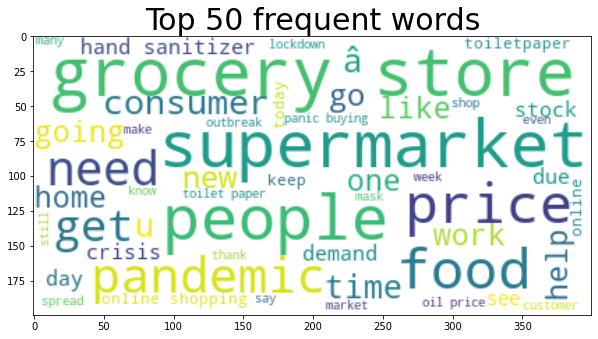

In [13]:
display_wordcloud(df,50, stop_words)

In [14]:
# Remove the stop words from the text
def remove_stopwords(texts, stop_words = stop_words):
    return [i for i in texts if i not in stop_words]
# https://elibooklover.github.io/Tutorials/Python/topicmodelingLDA/
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
# Get data in words for each tweet
def get_data_words(df):

    data = df["text_processed"].values.tolist()

    # Get a list of text for each tweet
    data_words = df["text_processed"].apply(lambda text : word_tokenize(text))
    # Remove stop words
    data_words = data_words.apply(lambda text : remove_stopwords(text)).tolist()
    # Remove stem
    data_words = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_words

In [15]:
data_words = get_data_words(df)

In [95]:
# save(data_words, "data_words")
# data_words=load("data_words")

In [17]:
# Range for topic numbers
min_topic = 2
max_topic = 50

### Models

#### LDA

In [18]:
# Preprocess data for LDA
def preprocess_LDA(data_words):

    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return id2word, corpus


id2word, corpus = preprocess_LDA(data_words)
# Apply the LDA model
def apply_LDA(data_words, min_topics = 2, max_topics=5):
    # id2word, data_words, corpus = preprocess_LDA(data_words_origin)
    
    # Apply the LDA model
    perplexity_list = dict()
    coherence_list = dict()
    lda_models_list = dict()

    for num_topics in range(min_topics,max_topics+1):
        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state = 5)

        # https://radimrehurek.com/gensim/models/ldamodel.html
        # https://stats.stackexchange.com/questions/322809/inferring-the-number-of-topics-for-gensims-lda-perplexity-cm-aic-and-bic
        bound = lda_model.log_perplexity(corpus)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word)
        coherence_lda = coherence_model_lda.get_coherence()
        
        perplexity = 2**(-bound)

        # Store values
        perplexity_list[num_topics] = perplexity
        coherence_list[num_topics]=coherence_lda
        lda_models_list[num_topics]=lda_model

        print(f"Topic {num_topics} Done: Perplexity: {perplexity}  Coherence Score: {coherence_lda}")

    return perplexity_list, coherence_list, lda_models_list

# Get top tweets for each topic
def get_top_tweets(model, corpus, topic_num, max_doc):
    topic_dict = {i: [] for i in range(topic_num)} 
    for tweet_idx in range(len(corpus)):
        topic_vector = model[corpus[tweet_idx]]
        for topicID, prob in topic_vector:
            topic_dict[topicID].append((tweet_idx, prob))

    topic_top_tweets = dict()
    for topicID, probs in topic_dict.items():
        doc_probs = sorted(probs, key = lambda x: x[1], reverse=True)[:max_doc]
        # print(doc_probs)
        topic_top_tweets[topicID] = doc_probs[:max_doc]

    return topic_top_tweets

# Display tweets in proper format
def display_text_LDA(topic_top_tweets, topic_idx):
    tweets_idx = [i[0] for i in topic_top_tweets[topic_idx]]
    return df.iloc[tweets_idx]["OriginalTweet"].values

In [19]:
# Run LDA
perplexity_result, coherence_result, lda_models_list = apply_LDA(data_words,  min_topic, max_topic)

Topic 2 Done: Perplexity: 250.6170913373931  Coherence Score: 0.2737377332918203
Topic 3 Done: Perplexity: 264.0165619540991  Coherence Score: 0.25979347904559086
Topic 4 Done: Perplexity: 277.9622340588115  Coherence Score: 0.289251559746144
Topic 5 Done: Perplexity: 286.0562234607956  Coherence Score: 0.31295505887215075
Topic 6 Done: Perplexity: 296.14929652022374  Coherence Score: 0.3451471329944462
Topic 7 Done: Perplexity: 304.84300832094885  Coherence Score: 0.34303830954810305
Topic 8 Done: Perplexity: 312.43215538954337  Coherence Score: 0.3763501369544396
Topic 9 Done: Perplexity: 323.03111611640605  Coherence Score: 0.3252192562292966
Topic 10 Done: Perplexity: 330.2952141374  Coherence Score: 0.35631331066566346
Topic 11 Done: Perplexity: 336.0350532668498  Coherence Score: 0.3499718093448583
Topic 12 Done: Perplexity: 346.2491469875786  Coherence Score: 0.3602303409013068
Topic 13 Done: Perplexity: 350.82875311916564  Coherence Score: 0.3484236012557126
Topic 14 Done: Perp

In [20]:
# save(perplexity_result, "perplexity_lda")
# save(coherence_result, "coherence_lda")
# save(lda_models_list,"models_lda")

In [21]:
# lda_models_list=load("models_lda")
# perplexity_result=load("perplexity_lda")
# coherence_result=load("coherence_lda")

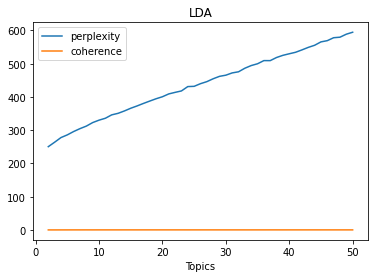

In [22]:
# Plot results
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_result.values()), label = "perplexity")
plt.plot(x,list(coherence_result.values()), label = "coherence")
plt.xlabel("Topics")
plt.title("LDA")
plt.legend()
plt.show()

In [23]:
id2word, corpus = preprocess_LDA(data_words)
topic_num = 8
topic_top_tweets = get_top_tweets(lda_models_list[topic_num], corpus, topic_num, 20)

In [24]:
# Print out topic words
pprint(lda_models_list[topic_num].print_topics())

[(0,
  '0.044*"store" + 0.042*"grocery" + 0.022*"go" + 0.021*"supermarket" + '
  '0.014*"get" + 0.009*"toiletpaper" + 0.009*"socialdistancing" + '
  '0.009*"shopping" + 0.009*"people" + 0.008*"work"'),
 (1,
  '0.019*"online" + 0.013*"shopping" + 0.012*"people" + 0.010*"price" + '
  '0.009*"food" + 0.008*"go" + 0.008*"help" + 0.008*"get" + 0.007*"store" + '
  '0.006*"time"'),
 (2,
  '0.036*"food" + 0.012*"demand" + 0.011*"consumer" + 0.009*"help" + '
  '0.007*"supermarket" + 0.007*"bank" + 0.007*"stock" + 0.006*"people" + '
  '0.006*"need" + 0.005*"essential"'),
 (3,
  '0.036*"price" + 0.016*"food" + 0.011*"supply" + 0.007*"time" + '
  '0.007*"demand" + 0.007*"lockdown" + 0.006*"go" + 0.006*"say" + '
  '0.006*"people" + 0.006*"scam"'),
 (4,
  '0.032*"sanitizer" + 0.031*"hand" + 0.022*"supermarket" + 0.017*"worker" + '
  '0.013*"mask" + 0.012*"people" + 0.009*"make" + 0.008*"use" + 0.007*"store" '
  '+ 0.006*"price"'),
 (5,
  '0.037*"consumer" + 0.013*"business" + 0.010*"easter" + 0.008*

In [25]:
# Print out topic tweets
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_LDA(topic_top_tweets,i))
    print()

Topic 0
array(['Stepped out after 7 days self isolation to get food Good to see my local Carrefour supermarket putting in place measures on physical distancing at the checkout counters In aisles people seem to abiding Most items includ fresh fruits vegetables available',
       "It's quite true. I walked to grocery store yesterday at 5pm (peak rush hour usually) and I was able to cross mid street because there were a lot less cars out there. There's still folks around but it was for groceries typically. #coronavirus going real ham. Now to see markets... https://t.co/eqWtCjtutH",
       'Hey, can yÂ\x92all stop panic buying groceries? My @HEB curbside is AN ENTIRE WEEK OUT. This never happens. \r\r\n\r\r\nI appreciate all of the hard working grocery store people. I know how stressful it is during a busy time. Keep it up!! \r\r\n\r\r\nFor the rest of you...chill out.\r\r\n#Hoarding #Covid_19',
       'My Mom amp Dad are getting worried about me working at the grocery store because of the

#### NMF

In [92]:
# https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
def calculate_coherence( w2v_model, term_rankings):
    overall_coherence = 0.0
    word_list = w2v_model.wv.vocab
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if (pair[0] in word_list) and (pair[1]  in word_list):
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)
# https://stackoverflow.com/questions/54941966/how-can-i-calculate-perplexity-using-nltk
# Self-defined method to calculate the perplexity

def calculate_perplexity_NMF(NMF_result, topic_num, top_words):
    word_prob = dict()
    for i in range(topic_num):
        for word in NMF_result[i]:
            if word in word_prob.keys():
                word_prob[word] += 1
            else:
                word_prob[word] = 0

    word_prob = {key: value/topic_num for key, value in word_prob.items()}

    for i in range(topic_num):
        perplexity = 0
        for word in NMF_result[i]:
            if word_prob[word] != 0:
                perplexity += np.log2(word_prob[word])
                # print(perplexity,word_prob[word])

    perplexity /= (top_words*topic_num)
    return np.power(2, -perplexity)

# Apply NMF
def apply_NMF(data_words,min_topic,max_topic, top_words = 5):
    # vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1), min_df = 0.01)
    vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1))
    X = vect.fit_transform([" ".join(i) for i in data_words])
    w2v_model = Word2Vec(sentences= data_words, min_count=1)

    coherence_results = dict()
    topic_results_list = dict()
    topic_tweets_results= dict()
    perplexity_results = dict()
    # X(document, words) = mode.transform(X)(document, topic_number) * components_df(topic_number, words)

    for topic_num in range(min_topic, max_topic+1):
        topic_results = dict()
        # Define model
        model = NMF(n_components=topic_num, random_state=5)
        model.fit(X)

        features = vect.get_feature_names()
        components_df = pd.DataFrame(model.components_, columns=features)

        term_rankings = []

        for topic_idx, probability in enumerate(model.components_):
            # print(f"Topic {topic_idx}: ", end="")
            top_words_idx = probability.argsort()[:-top_words - 1:-1]
            word_results = ", ".join(features[i] for i in top_words_idx)
            # print(word_results)
            topic_results[topic_idx] = word_results.split(", ")


            term_rankings.append(topic_results[topic_idx])

        # print()
        perplexity = calculate_perplexity_NMF(topic_results,topic_num = topic_num, top_words = top_word)
        topic_tweets = pd.DataFrame(model.transform(X))
        topic_tweets_results[topic_num] = topic_tweets
        perplexity_results[topic_num] = perplexity
        topic_results_list[topic_num] = topic_results

        coherence = calculate_coherence(w2v_model,term_rankings)
        coherence_results[topic_num] = coherence

        print(f"Topic: {topic_num}      Perplexity: {perplexity}      Coherence: {coherence}")
    return topic_results_list, topic_tweets_results, perplexity_results, coherence_results      

# Display the tweets for each topic
def display_text_NMF(topic_tweets, topic_idx, max_doc=20):

    idx = topic_tweets.sort_values(by=topic_idx, ascending=False).head(max_doc).index
    return df.iloc[idx]["OriginalTweet"].values


In [97]:
top_word = 20
# Apply NMF model
topic_results_list, topic_tweets_results, perplexity_results, coherence_results = apply_NMF(data_words, min_topic,max_topic, top_words = top_word)

Topic: 2      Perplexity: 1.0717734625362931      Coherence: 0.6459773592258755
Topic: 3      Perplexity: 1.2090800726426305      Coherence: 0.6579300433266582
Topic: 4      Perplexity: 1.2249203730799776      Coherence: 0.6653474602456155
Topic: 5      Perplexity: 1.0978218315308366      Coherence: 0.6575906488926787
Topic: 6      Perplexity: 1.05543086789017      Coherence: 0.6821788078990944
Topic: 7      Perplexity: 1.1805563181680896      Coherence: 0.7034418565998399
Topic: 8      Perplexity: 1.1516943208503627      Coherence: 0.703989353403449
Topic: 9      Perplexity: 1.1201823977673016      Coherence: 0.7080699094467693
Topic: 10      Perplexity: 1.0653056984176261      Coherence: 0.7124646189887274
Topic: 11      Perplexity: 1.1325955291456242      Coherence: 0.7088369543322028
Topic: 12      Perplexity: 1.1290281509154698      Coherence: 0.7263004144316006
Topic: 13      Perplexity: 1.1128450700808334      Coherence: 0.7343092845753673
Topic: 14      Perplexity: 1.1174001660

In [29]:
# save(topic_results_list, "topic_results_list_nmf")
# save(topic_tweets_results, "topic_tweets_results_nmf")
# save(perplexity_results, "perplexity_results_nmf")

In [99]:
# Plot result
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_results.values()), label = "Perplexity")
plt.plot(x,list(coherence_results.values()), label = "Coherence")
plt.xlabel("Topics")
plt.ylabel("Perplexity")
plt.title("NMF")
plt.legend()
plt.show()

In [31]:
# topic_tweets_results = load("topic_tweets_results_nmf")
# topic_results_list = load("topic_results_list_nmf")

In [32]:
topic_num = 6

In [33]:
# Print topic words
for key, value in topic_results_list[topic_num].items():
    print(f"topic {key}: ", ", ".join(value))

topic 0:  store, grocery, go, worker, work, get, people, retail, employee, time, online, shopping, line, thank, close, day, say, home, see, essential
topic 1:  price, oil, low, market, pandemic, due, increase, gas, fall, high, demand, drop, time, see, take, supply, say, crisis, global, go
topic 2:  food, panic, stock, demand, buy, supply, need, people, bank, help, buying, get, increase, due, chain, say, shortage, pandemic, stop, keep
topic 3:  supermarket, people, go, get, work, worker, shop, shelf, time, shopping, home, need, buy, day, staff, online, see, delivery, local, take
topic 4:  consumer, online, business, pandemic, shopping, change, impact, help, behavior, new, time, crisis, report, good, demand, due, see, take, product, economy
topic 5:  hand, sanitizer, make, use, mask, wash, soap, help, alcohol, stay, glove, home, face, need, safe, water, keep, bottle, get, people


In [34]:
# Print tweets
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_NMF(topic_tweets_results[topic_num], i, max_doc=20))
    print()

Topic 0
array(['I know a lot of grocery stores are low on stock of some items. If you need something right away, try the Dollar Store, bodegas, 7-11, drug stores or ask friends/neighbors. I found some things the grocery store was sold out of at the Dollar Store yesterday. #coronavirus',
       "Had to stop at 4 stores. Only health food store employees had masks, not fabric store w/ mask making customers, not lg grocery stores, not Fed. Post Office. #SocialDistancing won't work if store employees aren't protected &amp; protecting us.?\r\r\n\r\r\n#Montana #Helena #COVID19 #coronavirus",
       "Sick people - Please STOP going to the grocery store! Order delivery! It's called self isolation! I'm tired of seeing people with coronavirus at the grocery store. Restaurants are more sanitary than the grocery stores! I'm ordering take-out, it's safer! #coronavirus",
       'If you can use an app and pick-up at the grocery store that is best. If the grocery stores are not app capable they should 

#### BTM

In [35]:
# Apply BTM model
def apply_BTM(data_words, min_topic=2,max_topic=5, top_words=10):
    texts = [" ".join(i) for i in data_words]
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    biterms = btm.get_biterms(docs_vec)

    perplexity_list = dict()
    coherence_list = dict()
    BTM_model_list = dict()
    phi_list = dict()

    for num_topic in range(min_topic, max_topic+1):
        # Initializing and running model
        model = btm.BTM(X, vocabulary, seed=5, T=num_topic, M=top_words)
        model.fit(biterms, iterations=20,verbose =False)

        perplexity = model.perplexity_
        coherence = np.average(model.coherence_)

        print(f"Topic {num_topic} Done: Perplexity: {perplexity}  Coherence Score: {coherence}")

        phi = tmp.get_phi(model)
        perplexity_list[num_topic] = perplexity
        coherence_list[num_topic] = coherence
        BTM_model_list[num_topic] = model
        phi_list[num_topic] = phi
    return perplexity_list, coherence_list, BTM_model_list, phi_list

# Display topic words
def display_BTM(phi, words_num=5):
    for i in phi.columns:
        top_words = phi.sort_values(by=i, ascending = False).head(words_num).index.tolist()
        word_results = ", ".join(top_words) 
        print(f"Topic {i}: {word_results}")
# Display tweets
def display_text_BTM(model,data_words,max_doc=20):
    texts = [" ".join(i) for i in data_words]
    return btm.get_top_topic_docs(texts, model.matrix_docs_topics_, docs_num = max_doc)

In [36]:
# Run BTM
perplexity_result, coherence_result, BTM_model_list, phi_list= apply_BTM(data_words,min_topic,max_topic)

Topic 2 Done: Perplexity: 68537537202.90873  Coherence Score: -115.15455866258


/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'


Topic 3 Done: Perplexity: inf  Coherence Score: -112.62665341008005
Topic 4 Done: Perplexity: 3.242392218353342e+292  Coherence Score: -114.07491934303334
Topic 5 Done: Perplexity: 4.8927557749062136e+297  Coherence Score: -116.4797715010387
Topic 6 Done: Perplexity: 2.333876302270504e+43  Coherence Score: -114.72335283213549
Topic 7 Done: Perplexity: 3.110409196258611e+260  Coherence Score: -112.05755256955419
Topic 8 Done: Perplexity: 1.1336685694669985e+116  Coherence Score: -117.50736593058973
Topic 9 Done: Perplexity: 7.541086147427301e+34  Coherence Score: -117.54514862233539
Topic 10 Done: Perplexity: 1.0  Coherence Score: -115.187736071978
Topic 11 Done: Perplexity: 1.2315099335916964e+203  Coherence Score: -113.30562871465335
Topic 12 Done: Perplexity: 6.178440962962586e+269  Coherence Score: -112.96690846088353
Topic 13 Done: Perplexity: inf  Coherence Score: -118.54328056633169
Topic 14 Done: Perplexity: inf  Coherence Score: -114.19905781792896
Topic 15 Done: Perplexity: in

In [37]:
# save(perplexity_result, "perplexity_btm")
# save(coherence_result, "coherence_btm")
# save(BTM_model_list,"models_btm")
# save(phi_list,"phi_btm")

In [38]:
# perplexity_result=load("perplexity_btm")
# coherence_result=load( "coherence_btm")
# BTM_model_list=load("models_btm")
# phi_list=load("phi_btm")

In [39]:
# Plot result
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_result.values()), label = "perplexity")
plt.plot(x,list(coherence_result.values()), label = "coherence")
plt.xlabel("Topics")
plt.title("BTM")
plt.legend()
plt.show()

In [40]:
topic_num = 6
phi = phi_list[topic_num]

In [41]:
# tmp.calc_terms_probs_ratio(phi, topic=4, lambda_=1)
# terms_probs.sort_values(by="Probability", ascending = False).head(10)["Terms"].to_list()
# Display topic words
for i in phi.columns:
    top_words = phi.sort_values(by=i, ascending = False).head(10).index.tolist()
    word_results = ", ".join(top_words) 
    print(f"Topic {i}: {word_results}")

Topic 0: consumer, online, shopping, price, store, business, help, time, pandemic, retail
Topic 1: supermarket, go, people, store, hand, grocery, sanitizer, get, mask, buy
Topic 2: store, grocery, supermarket, worker, people, go, work, get, food, delivery
Topic 3: food, panic, people, price, buy, need, supermarket, store, stock, go
Topic 4: food, price, consumer, hand, supply, supermarket, sanitizer, store, people, demand
Topic 5: price, consumer, oil, demand, pandemic, market, due, impact, low, food


In [42]:
# Display tweets
display_text_BTM(BTM_model_list[topic_num],data_words)

topic0  \
0   trigger profiteer essential item sell black ma...   
1   fijian competition consumer commission urge fi...   
2   warning panic buyer still active government su...   
3   goal protect customer help get back foot learn...   
4   grocer reassure customer food supply demand so...   
5   consumer remain calm mzansi food supply system...   
6   doom gloom outbreak completely upend world kno...   
7   unexpected upshot kid ask thing grocery store ...   
8   crisis consumer shop online ever millennial sa...   
9   grocery store dog walk good samaritan stepping...   
10  friend stick lose access food water demand tak...   
11  important update still reach social handle web...   
12  trade business dudetestingimagine consumer con...   
13            cash carry spread launder cash fee send   
14  spread join peer shut playspace cancel event s...   
15  ask evening supermarket angry fellow cock meat...   
16  grocery store manager isolation period theoffi...   
17  people stay home force increasingly shop onlin...   
18  consumer affair issue circular direct commerce...   
19  cheerio maker generalmill raise adjusted profi...   

                                               topic1  \
0   trigger profiteer essential item sell black ma...   
1   fijian competition consumer commission urge fi...   
2   warning panic buyer still active government su...   
3   goal protect customer help get back foot learn...   
4   grocer reassure customer food supply demand so...   
5   consumer remain calm mzansi food supply system...   
6   doom gloom outbreak completely upend world kno...   
7   unexpected upshot kid ask thing grocery store ...   
8   crisis consumer shop online ever millennial sa...   
9   grocery store dog walk good samaritan stepping...   
10  friend stick lose access food water demand tak...   
11  important update still reach social handle web...   
12  trade business dudetestingimagine consumer con...   
13            cash carry spread launder cash fee send   
14  spread join peer shut playspace cancel event s...   
15  ask evening supermarket angry fellow cock meat...   
16  grocery store manager isolation period theoffi...   
17  people stay home force increasingly shop onlin...   
18  consumer affair issue circular direct commerce...   
19  cheerio maker generalmill raise adjusted profi...   

                                               topic2  \
0   trigger profiteer essential item sell black ma...   
1   fijian competition consumer commission urge fi...   
2   warning panic buyer still active government su...   
3   goal protect customer help get back foot learn...   
4   grocer reassure customer food supply demand so...   
5   consumer remain calm mzansi food supply system...   
6   doom gloom outbreak completely upend world kno...   
7   unexpected upshot kid ask thing grocery store ...   
8   crisis consumer shop online ever millennial sa...   
9   grocery store dog walk good samaritan stepping...   
10  friend stick lose access food water demand tak...   
11  important update still reach social handle web...   
12  trade business dudetestingimagine consumer con...   
13            cash carry spread launder cash fee send   
14  spread join peer shut playspace cancel event s...   
15  ask evening supermarket angry fellow cock meat...   
16  grocery store manager isolation period theoffi...   
17  people stay home force increasingly shop onlin...   
18  consumer affair issue circular direct commerce...   
19  cheerio maker generalmill raise adjusted profi...   

                                               topic3  \
0   trigger profiteer essential item sell black ma...   
1   fijian competition consumer commission urge fi...   
2   warning panic buyer still active government su...   
3   goal protect customer help get back foot learn...   
4   grocer reassure customer food supply demand so...   
5   consumer remain calm mzansi food supply system...   
6   doom gloom outbreak completely upend world kno... 

#### CorEx

In [43]:
#github example here: https://github.com/gregversteeg/corex_topic
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

# Apply corex model
def apply_Corex(data_words, min_topic=2, max_topic=10, anchor_words = None):

    tc_list = dict()
    model_list = dict()

    vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1), min_df = 0.01)
    X = vect.fit_transform([" ".join(i) for i in data_words])


    X = ss.csr_matrix(X)
    for num_topic in range(min_topic, max_topic+1):
        # Train the CorEx topic model
        model = ct.Corex(n_hidden=num_topic, verbose = False, seed=5)  # Define the number of latent (hidden) topics to use.
        # topic_model.fit(X, words=words, docs=docs)
        words = vect.get_feature_names()
        model.fit(X, words = words, anchors=anchor_words)
        print(f"Topic {num_topic} Total Covraiance: {model.tc}")
        model_list[num_topic] = model
        tc_list[num_topic] = model.tc
    return tc_list, model_list

# Display topic words
def display_corex(topics, words_num=5):
    for topic_idx,topic in enumerate(topics):
        
        # w: word, mi: mutual information, s: sign
        topic = [w if s > 0 else ('~'+w) for w,_,s in topic]
        results = ", ".join(topic[:words_num])
        print(f"Topic {topic_idx}: {results}")

# Display tweets
def display_text_corex(model, topic_idx, max_doc=20):
    top_tweets = model.get_top_docs(topic=topic_idx, n_docs=max_doc)
    idx = [i[0] for i in top_tweets]
    return df.iloc[idx]["OriginalTweet"].values

In [44]:
# Run corex model without anchor words
tc_result, corex_models = apply_Corex(data_words,min_topic, max_topic)

Topic 2 Total Covraiance: 0.6796313515935585
Topic 3 Total Covraiance: 0.7131143642561579
Topic 4 Total Covraiance: 0.9234028618095651
Topic 5 Total Covraiance: 0.8667332151514651
Topic 6 Total Covraiance: 0.995049004269764
Topic 7 Total Covraiance: 1.0393319273258572
Topic 8 Total Covraiance: 1.015681722946196
Topic 9 Total Covraiance: 0.9681177055481763
Topic 10 Total Covraiance: 1.0888262016093406
Topic 11 Total Covraiance: 1.0620752153360877
Topic 12 Total Covraiance: 1.1989962755864674
Topic 13 Total Covraiance: 1.0404149159643177
Topic 14 Total Covraiance: 1.031165763897683
Topic 15 Total Covraiance: 1.112850848183793
Topic 16 Total Covraiance: 1.1745030663707459
Topic 17 Total Covraiance: 1.1313805918049533
Topic 18 Total Covraiance: 1.053228320033918
Topic 19 Total Covraiance: 1.0903365715582745
Topic 20 Total Covraiance: 1.0874753028593682
Topic 21 Total Covraiance: 1.0847188528340568
Topic 22 Total Covraiance: 1.080533795961197
Topic 23 Total Covraiance: 0.9985794652140983
To

In [45]:
# save(tc_result, "tc_corex")
# save(corex_models, "models_corex")

In [46]:
# tc_result=load( "tc_corex")
# corex_models = load( "models_corex")

In [47]:
# tc_result = load("tc_corex")

In [48]:
# Plot results
plt.figure(figsize = (15, 5))
plt.bar(tc_result.keys(), tc_result.values(),width = 0.7)
plt.xlabel("Topics")
plt.ylabel("Total Correlation")
plt.title("CorEx")

Text(0.5, 1.0, 'CorEx')

In [49]:
# Display topic words
topic_num = 12
display_corex(corex_models[topic_num].get_topics())

Topic 0: store, grocery, ~consumer, retail, worker
Topic 1: price, oil, ~supermarket, low, gas
Topic 2: hand, sanitizer, mask, glove, wear
Topic 3: online, shopping, shop, delivery, order
Topic 4: food, demand, supply, stock, chain
Topic 5: toilet, paper, toiletpaper, roll, find
Topic 6: stay, social, home, safe, distancing
Topic 7: go, people, get, shelf, empty
Topic 8: panic, buying, buy, stop, fear
Topic 9: support, help, community, business, small
Topic 10: week, last, month, next, year
Topic 11: change, behavior, shift, new, pandemic


In [50]:
# Display tweets
model = corex_models[topic_num]
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_corex(model, i, max_doc=20))
    print()

Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(['We wanted to take a moment to thank all of those working on the front lines to combat COVID-19. Healthcare workers, those in manufacturing and transportation, retail and grocery store employees, scientists, and everyone working from home to flatten the curve: THANK YOU. https://t.co/crCVrL9CQI',
       'All stores (except: grocery stores or pharmacies) should not have open doors. No one needs to buy anything other than essentials right now. CLOSE YOUR DOORS, keep your employees and customers safe! #coronavirus #closeyourdoors',
       'something to think of for hospital staff EMTs social workers counselors emergency service repair grocery essential retail store employees anyone i forgot amp friends family worth the read',
       'THANK YOU GROCERY STORE EMPLOYEES, FARMERS, TRUCKERS, HEALTHCARE WORKERS, RETAIL EMPLOYEES THAT ARE STILL WORKING, AND ALL OTHER ESSENTIAL INDIVIDUALS OFFERING YOUR 

In [51]:
# Run corex with anchor words
tc_result_anchor, corex_models_anchor = apply_Corex(data_words,min_topic, max_topic,anchor_words=["food"])

Topic 2 Total Covraiance: 0.6300917160420514
Topic 3 Total Covraiance: 0.8133686344979423
Topic 4 Total Covraiance: 0.9073658327153103
Topic 5 Total Covraiance: 0.8539569826573271
Topic 6 Total Covraiance: 0.9532723864497616
Topic 7 Total Covraiance: 0.9838789089341891
Topic 8 Total Covraiance: 1.0846508099529963
Topic 9 Total Covraiance: 1.076433787430413
Topic 10 Total Covraiance: 1.015135137902477
Topic 11 Total Covraiance: 1.1161074677069591
Topic 12 Total Covraiance: 1.2067696320085515
Topic 13 Total Covraiance: 1.0891268239150675
Topic 14 Total Covraiance: 1.2184295670201652
Topic 15 Total Covraiance: 1.1863494850537992
Topic 16 Total Covraiance: 1.2170767005866634
Topic 17 Total Covraiance: 1.1641372097553968
Topic 18 Total Covraiance: 1.046648240829894
Topic 19 Total Covraiance: 1.0922479113863637
Topic 20 Total Covraiance: 1.0673711136191435
Topic 21 Total Covraiance: 1.2334154988729555
Topic 22 Total Covraiance: 1.1238833421091727
Topic 23 Total Covraiance: 1.0735491781213873

In [52]:
# save(tc_result_anchor, "tc_corex_anchor")
# save(corex_models_anchor, "models_corex_anchor")
# tc_result_anchor = load("tc_result_anchor")

In [53]:
# tc_result_anchor = load( "tc_corex_anchor")
# corex_models_anchor= load( "models_corex_anchor")

Text(0.5, 1.0, 'CorEx with anchor word "food"')

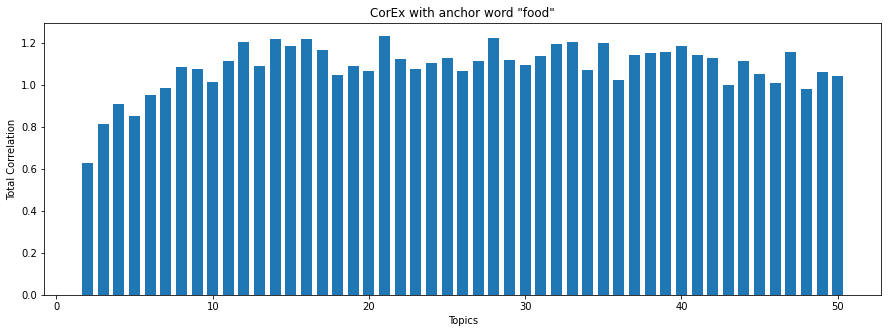

In [54]:
plt.figure(figsize = (15, 5))
plt.bar(tc_result_anchor.keys(), tc_result_anchor.values(),width = 0.7)
plt.xlabel("Topics")
plt.ylabel("Total Correlation")
plt.title("CorEx with anchor word \"food\"")

In [55]:
topic_num = 12
display_corex(corex_models_anchor[topic_num].get_topics())

Topic 0: food, panic, stock, buy, buying
Topic 1: make, sure
Topic 2: consumer, ~supermarket, demand, impact, business
Topic 3: people, get, work, time, itâ
Topic 4: online, shopping, shop, delivery, order
Topic 5: toilet, paper, toiletpaper, roll, find
Topic 6: price, oil, fall, market, high
Topic 7: stay, social, safe, distancing, home
Topic 8: low, year, gas, old, drop
Topic 9: store, grocery, retail, employee, go
Topic 10: hand, sanitizer, mask, glove, wear
Topic 11: worker, driver, health, staff, thank


In [56]:
model = corex_models_anchor[topic_num]
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_corex(model, i, max_doc=20))
    print()

Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(["@munro_burton There's empty shelves because of the panic buying. There's no issue at all with the food supply chain. *BUT THERE WILL BE IF PEOPLE KEEP BUYING 10kg rice THEY'LL STILL BE USING UP NEXT CHRISTMAS.* #Sainsburys #COVID2019 #JeremyVine #LeaveEno",
       "Supplies of food &amp; toiletry items are just fine, it's panic buying &amp; hoarding that's emptying shelves faster than truckers can transport the supplies. #Coronavirus is bad enough, let's not make it worse by denying people fair access to stuff they need at their stores. Chill folks",
       'No shortage of food here As a wave of panic buying strikes many of the nation s biggest retailers due to as they work around the clock to transport and supply goods to fill empty shelves',
       "Nice assurance from #Malaysia PM but there are panic buying &amp; shortages of essential supplies in Msia too. It's political suicide for the n

### Experiment 1 - Topics Over Time(Seasons)

#### Data Prepare

In [57]:
df

UserName  ScreenName                        Location     TweetAt  \
0         29779       74731            Brooklyn / the world  01-04-2020   
1         29349       74301   Ginninderra Creek Canberra Oz  01-04-2020   
2         29350       74302                    Brooklyn, NY  01-04-2020   
3         29351       74303                          London  01-04-2020   
4         29352       74304                  las cruces,nm   01-04-2020   
...         ...         ...                             ...         ...   
32562     42982       87934       Adelaide, South Australia  12-04-2020   
32563     42979       87931                Karachi Pakistan  12-04-2020   
32564     42978       87930                         NY & NJ  12-04-2020   
32565     42975       87927                Bedford, England  12-04-2020   
32566     42847       87799                   Kenya??AFRICA  12-04-2020   

                                           OriginalTweet           Sentiment  \
0      World risks food crisis in wake of coronavirus...  Extremely Negative   
1      The Canberra Relief Network CRN is the ACT Gov...            Positive   
2      I worked at a nightclub. I lived shift to shif...  Extremely Positive   
3      Think all the 'extra' supermarkets need to clo...            Negative   
4      Lowe's closes Harper Woods store to customers ...            Positive   
...                                                  ...                 ...   
32562  Gratitunes is a consumer-generated music platf...  Extremely Positive   
32563  @RamzanChhipa Thanks @RamzanChhipa \r\r\n\r\r\...            Positive   
32564  "Yearly Passover Food Distribution" outdoor wi...            Positive   
32565  Coronavirus can linger in air for a long time,...            Positive   
32566  OPEC has agreed to Cut Oil Production by 9.7 M...            Positive   

        datetime  month                                            hashtag  \
0     2020-01-04      1                                                 []   
1     2020-01-04      1                                                 []   
2     2020-01-04      1                               [coronavirus, COVID]   
3     2020-01-04      1              [lockdown, coronavirus, Supermarkets]   
4     2020-01-04      1                                                 []   
...          ...    ...                                                ...   
32562 2020-12-04     12                                                 []   
32563 2020-12-04     12  [HandGloves, Mask, Sanitizer, COVID__19, Coron...   
32564 2020-12-04     12                                                 []   
32565 2020-12-04     12                                                 []   
32566 2020-12-04     12                                                 []   

                                          text_processed  
0      world risks food crisis in wake of coronavirus...  
1      the canberra relief network crn is the act gov...  
2      i worked at a nightclub i lived shift to shift...  
3      think all the  extra  supermarkets need to clo...  
4      lowe s closes harper woods store to customers ...  
...                                                  ...  
32562  gratitunes is a consumer generated music platf...  
32563   ramzanchhipa thanks  ramzanchhipa  handgloves...  
32564   yearly passover food distribution  outdoor wi...  
32565  coronavirus can linger in air for a long time ...  
32566  opec has agreed to cut oil production by   mil...  

[32567 rows x 10 columns]

In [58]:
# Create map of the season
season_dict = {
    1: "spring",
    2: "spring",
    3: "spring",
    4: "summer",
    5: "summer",
    6: "summer",
    7: "autumn",
    8: "autumn",
    9: "autumn",
    10: "winter",
    11: "winter",
    12: "winter",
}

In [59]:
df["season"] = df["month"].map(season_dict)

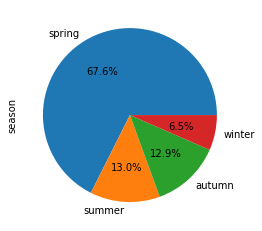

In [60]:
# Plot proportion of the data in season
df["season"].value_counts(normalize=True).plot.pie(autopct = "%.1f%%")

In [61]:
df_spring = df.loc[(df["season"]=="spring")].reset_index(drop=True)
df_summer = df.loc[(df["season"]=="summer")].reset_index(drop=True)
df_autumn = df.loc[(df["season"]=="autumn")].reset_index(drop=True)
df_winter = df.loc[(df["season"]=="winter")].reset_index(drop=True)

In [62]:
# Get data words for each season
data_words_list= {
    "spring":get_data_words(df_spring),
    "summer": get_data_words(df_summer),
    "autumn" : get_data_words(df_autumn),
    "winter" : get_data_words(df_winter)   
}

In [63]:
# save(data_words_list, "data_words_list_seasons")

In [64]:
# data_words_list = load("data_words_list_seasons")

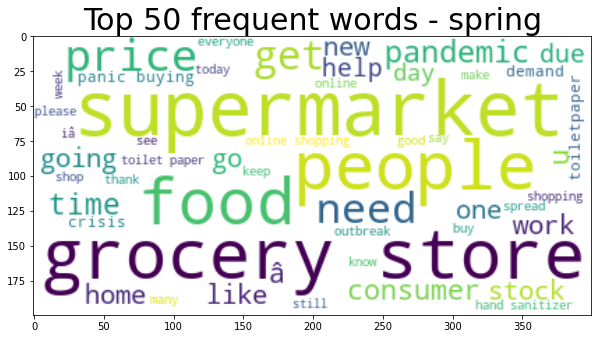

In [65]:
display_wordcloud(df_spring,50, stop_words=stop_words, title = "spring")

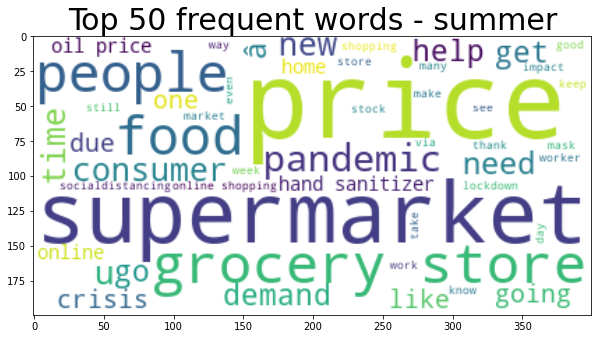

In [66]:
display_wordcloud(df_summer,50, stop_words=stop_words, title = "summer")

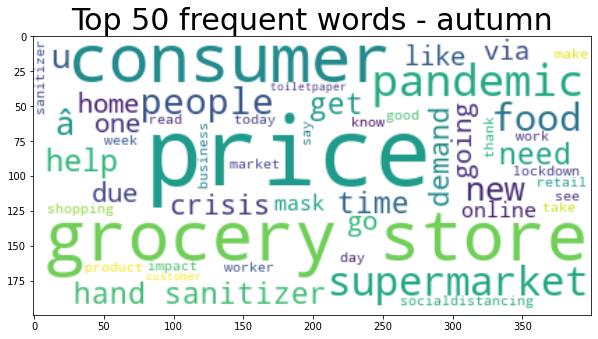

In [67]:
display_wordcloud(df_autumn,50, stop_words=stop_words, title = "autumn")

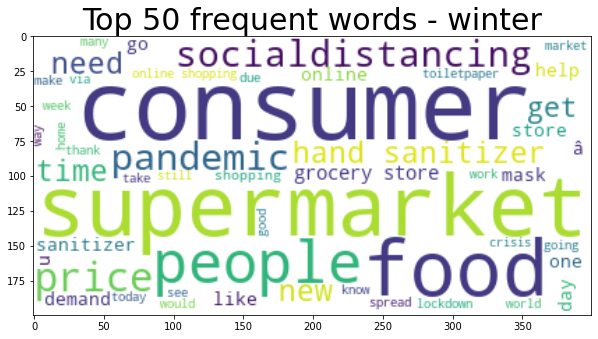

In [68]:
display_wordcloud(df_winter,50, stop_words=stop_words, title = "winter")

#### LDA

In [70]:
# Run LDA
perplexity_result, coherence_result, lda_result = dict(),dict(),dict()
for key, data_words_new in data_words_list.items():
    print(f"============================{key} Start LDA ============================")
    id2word, corpus = preprocess_LDA(data_words_new)
    perplexity, coherence, model = apply_LDA(data_words_new, min_topic, max_topic)
    perplexity_result[key] = perplexity
    coherence_result[key] = coherence
    lda_result[key] = model

# save(lda_result,f"season_lda")

============================spring Start LDA ============================
Topic 2 Done: Perplexity: 279.47236805095577  Coherence Score: 0.22639179292955847
Topic 3 Done: Perplexity: 284.1632654686013  Coherence Score: 0.30164935778032037
Topic 4 Done: Perplexity: 299.01726803154804  Coherence Score: 0.306749257116118
Topic 5 Done: Perplexity: 313.70890276115193  Coherence Score: 0.41039761766688815
Topic 6 Done: Perplexity: 322.2004859281834  Coherence Score: 0.3395566006705224
Topic 7 Done: Perplexity: 334.5594116596923  Coherence Score: 0.33484229687281786
Topic 8 Done: Perplexity: 342.78769659058804  Coherence Score: 0.32897578568868147
Topic 9 Done: Perplexity: 357.706743073258  Coherence Score: 0.31448760986167484
Topic 10 Done: Perplexity: 363.5640042536136  Coherence Score: 0.33279187155529755
Topic 11 Done: Perplexity: 372.8721678958499  Coherence Score: 0.2799302654714165
Topic 12 Done: Perplexity: 382.2146682107234  Coherence Score: 0.3236239728840031
Topic 13 Done: Perplexi

Topic 50 Done: Perplexity: 626.5468739192639  Coherence Score: 0.28624795177948203
============================summer Start LDA ============================


Topic 2 Done: Perplexity: 273.574640120182  Coherence Score: 0.23059296980123065


Topic 3 Done: Perplexity: 293.3269540425012  Coherence Score: 0.2549008823697467


Topic 4 Done: Perplexity: 318.4118768952756  Coherence Score: 0.2518022209230709


Topic 5 Done: Perplexity: 337.984298564167  Coherence Score: 0.24631853670005333


Topic 6 Done: Perplexity: 353.73135379315505  Coherence Score: 0.23772649229316148


Topic 7 Done: Perplexity: 370.2876752810507  Coherence Score: 0.24217910625412783


Topic 8 Done: Perplexity: 383.994508457341  Coherence Score: 0.25308938103359774


Topic 9 Done: Perplexity: 398.40925928879426  Coherence Score: 0.24901067006063593


Topic 10 Done: Perplexity: 409.0354028149433  Coherence Score: 0.2722950660079594


Topic 11 Done: Perplexity: 424.8383945359714  Coherence Score: 0.2805608400149005


Topic 12 Done: Perplexity: 438.8867524005431  Coherence Score: 0.2688983721725889


Topic 13 Done: Perplexity: 451.57340392937743  Coherence Score: 0.25027380300441404


Topic 14 Done: Perplexity: 464.18432867853426  Coherence Score: 0.2569771973206148


Topic 15 Done: Perplexity: 479.8497274506484  Coherence Score: 0.2956651765094716


Topic 16 Done: Perplexity: 491.24735496456526  Coherence Score: 0.2500329665500557


Topic 17 Done: Perplexity: 502.9533724416847  Coherence Score: 0.2869420270092982


Topic 18 Done: Perplexity: 514.9703743645066  Coherence Score: 0.2582584293828478


Topic 19 Done: Perplexity: 529.9942618149937  Coherence Score: 0.2615311308298529


Topic 20 Done: Perplexity: 540.9270197169332  Coherence Score: 0.27102237335059687


Topic 21 Done: Perplexity: 553.5949585919456  Coherence Score: 0.2688664313000439


Topic 22 Done: Perplexity: 562.81692635721  Coherence Score: 0.29204234462198597


Topic 23 Done: Perplexity: 583.5600586205163  Coherence Score: 0.2754768333671913


Topic 24 Done: Perplexity: 591.2103128573599  Coherence Score: 0.26754744530380975


Topic 25 Done: Perplexity: 601.393513237786  Coherence Score: 0.26774698613664777


Topic 26 Done: Perplexity: 611.402893592479  Coherence Score: 0.27149121090240913


Topic 27 Done: Perplexity: 624.6166786188757  Coherence Score: 0.2797658699661402


Topic 28 Done: Perplexity: 642.5243619209813  Coherence Score: 0.27465575763891625


Topic 29 Done: Perplexity: 646.9327019739529  Coherence Score: 0.26674387758648865


Topic 30 Done: Perplexity: 656.3545440068173  Coherence Score: 0.2709970112980176


Topic 31 Done: Perplexity: 671.3072172876907  Coherence Score: 0.28355059526664955


Topic 32 Done: Perplexity: 683.7303113515695  Coherence Score: 0.28949578449501023


Topic 33 Done: Perplexity: 689.8207819575658  Coherence Score: 0.2616107691648947


Topic 34 Done: Perplexity: 711.2073426280139  Coherence Score: 0.28487454076587426


Topic 35 Done: Perplexity: 710.6982744932698  Coherence Score: 0.28043938613340114


Topic 36 Done: Perplexity: 731.6464680581502  Coherence Score: 0.29653589378289186


Topic 37 Done: Perplexity: 746.9018975492654  Coherence Score: 0.28515704520321555


Topic 38 Done: Perplexity: 763.2304518304697  Coherence Score: 0.2844497196046132


Topic 39 Done: Perplexity: 767.0534862643202  Coherence Score: 0.2897712678410037


Topic 40 Done: Perplexity: 781.570391725233  Coherence Score: 0.2812887004997014


Topic 41 Done: Perplexity: 789.5530412801181  Coherence Score: 0.26924289528674045


Topic 42 Done: Perplexity: 797.3597799904173  Coherence Score: 0.307068448668615


Topic 43 Done: Perplexity: 814.0682643729851  Coherence Score: 0.2753614697637702


Topic 44 Done: Perplexity: 824.0134560295515  Coherence Score: 0.26916345656453927


Topic 45 Done: Perplexity: 833.0636767532408  Coherence Score: 0.26876585244680723


Topic 46 Done: Perplexity: 839.0629880358078  Coherence Score: 0.2840683170628693


Topic 47 Done: Perplexity: 847.3832833138368  Coherence Score: 0.29053023843230746


Topic 48 Done: Perplexity: 877.1779721390778  Coherence Score: 0.27499911283418293


Topic 49 Done: Perplexity: 879.2138014621469  Coherence Score: 0.2790191961269815


Topic 50 Done: Perplexity: 885.618084158935  Coherence Score: 0.29652456199367644
============================autumn Start LDA ============================


Topic 2 Done: Perplexity: 281.0886086160798  Coherence Score: 0.20547203511243317


Topic 3 Done: Perplexity: 302.7777949558164  Coherence Score: 0.23341713434839673


Topic 4 Done: Perplexity: 323.0779383982981  Coherence Score: 0.2405455765347583


Topic 5 Done: Perplexity: 341.78974112034683  Coherence Score: 0.21386952616880706


Topic 6 Done: Perplexity: 358.15928832790286  Coherence Score: 0.2565363100636584


Topic 7 Done: Perplexity: 373.92386988998027  Coherence Score: 0.23943967017592138


Topic 8 Done: Perplexity: 389.80937724476513  Coherence Score: 0.2482068050188841


Topic 9 Done: Perplexity: 406.0667524525394  Coherence Score: 0.26553308276611864


Topic 10 Done: Perplexity: 423.9603257303145  Coherence Score: 0.2503937332322598


Topic 11 Done: Perplexity: 435.77300549629564  Coherence Score: 0.23565986207746795


Topic 12 Done: Perplexity: 452.98872392518  Coherence Score: 0.2702255996954299


Topic 13 Done: Perplexity: 462.39776964444974  Coherence Score: 0.2760801887307812


Topic 14 Done: Perplexity: 474.9592363164829  Coherence Score: 0.2809240915475006


Topic 15 Done: Perplexity: 491.84848719435695  Coherence Score: 0.2648249534547574


Topic 16 Done: Perplexity: 503.29738006045136  Coherence Score: 0.2970452612180352


Topic 17 Done: Perplexity: 520.1977611086464  Coherence Score: 0.2944393096620817


Topic 18 Done: Perplexity: 530.622616396962  Coherence Score: 0.27707126147516176


Topic 19 Done: Perplexity: 543.7938542667259  Coherence Score: 0.2887641851776586


Topic 20 Done: Perplexity: 555.1505480248561  Coherence Score: 0.28223712776956467


Topic 21 Done: Perplexity: 567.0415799858941  Coherence Score: 0.28950312807309975


Topic 22 Done: Perplexity: 583.6937493507323  Coherence Score: 0.28422484123272534


Topic 23 Done: Perplexity: 591.9486246705421  Coherence Score: 0.28334846352467447


Topic 24 Done: Perplexity: 607.9566632861494  Coherence Score: 0.2899836051910713


Topic 25 Done: Perplexity: 615.2090768860942  Coherence Score: 0.27979373607498165


Topic 26 Done: Perplexity: 633.0349158529334  Coherence Score: 0.28086407602033137


Topic 27 Done: Perplexity: 647.0833206168729  Coherence Score: 0.27880393716187285


Topic 28 Done: Perplexity: 656.1686619609039  Coherence Score: 0.2689391164467073


Topic 29 Done: Perplexity: 668.6600800358916  Coherence Score: 0.2734010895490066


Topic 30 Done: Perplexity: 674.1039317342505  Coherence Score: 0.30430590657368334


Topic 31 Done: Perplexity: 691.2192041147466  Coherence Score: 0.2798057169997884


Topic 32 Done: Perplexity: 702.0273463092753  Coherence Score: 0.2744554979679867


Topic 33 Done: Perplexity: 711.3429165895975  Coherence Score: 0.29205807895185254


Topic 34 Done: Perplexity: 728.439145688323  Coherence Score: 0.2953514969148192


Topic 35 Done: Perplexity: 733.6387615588321  Coherence Score: 0.2737471239137251


Topic 36 Done: Perplexity: 744.7647946833263  Coherence Score: 0.2898959991231491


Topic 37 Done: Perplexity: 759.5536048215175  Coherence Score: 0.3096798300261205


Topic 38 Done: Perplexity: 772.40219627637  Coherence Score: 0.29054286500663057


Topic 39 Done: Perplexity: 779.9733149096011  Coherence Score: 0.2860584349882819


Topic 40 Done: Perplexity: 801.4371578077609  Coherence Score: 0.3054870508688252


Topic 41 Done: Perplexity: 805.1210174781611  Coherence Score: 0.29312037420438064


Topic 42 Done: Perplexity: 818.8605103462085  Coherence Score: 0.28315452425762533


Topic 43 Done: Perplexity: 829.7322158268911  Coherence Score: 0.28998742417287404


Topic 44 Done: Perplexity: 841.0744142816391  Coherence Score: 0.30531302716888464


Topic 45 Done: Perplexity: 854.6701778049961  Coherence Score: 0.27458044152886163


Topic 46 Done: Perplexity: 866.9448504294105  Coherence Score: 0.3103985988984991


Topic 47 Done: Perplexity: 880.4085212298545  Coherence Score: 0.27996745020118297


Topic 48 Done: Perplexity: 896.9663137577979  Coherence Score: 0.30066298414347253


Topic 49 Done: Perplexity: 897.458426631392  Coherence Score: 0.31196508625568026


Topic 50 Done: Perplexity: 910.766149741212  Coherence Score: 0.3039308062424192
============================winter Start LDA ============================


Topic 2 Done: Perplexity: 303.6522341862504  Coherence Score: 0.2671698996921733


Topic 3 Done: Perplexity: 337.7181334530343  Coherence Score: 0.29076346525880925


Topic 4 Done: Perplexity: 369.2629592146246  Coherence Score: 0.3064129615662834


Topic 5 Done: Perplexity: 398.6640330598547  Coherence Score: 0.2817960386604176


Topic 6 Done: Perplexity: 423.99445583767397  Coherence Score: 0.2649996705008652


Topic 7 Done: Perplexity: 449.5490718272336  Coherence Score: 0.2941264383802268


Topic 8 Done: Perplexity: 472.15478810182645  Coherence Score: 0.31325804392097645


Topic 9 Done: Perplexity: 491.76897605775383  Coherence Score: 0.31402712095087654


Topic 10 Done: Perplexity: 509.4130788663723  Coherence Score: 0.32320925503858666


Topic 11 Done: Perplexity: 532.9595895216863  Coherence Score: 0.295356324975768


Topic 12 Done: Perplexity: 557.1578405389986  Coherence Score: 0.297460100716635


Topic 13 Done: Perplexity: 579.3964618836815  Coherence Score: 0.31626934057286044


Topic 14 Done: Perplexity: 590.2544227836748  Coherence Score: 0.30825313913017877


Topic 15 Done: Perplexity: 622.1293368846874  Coherence Score: 0.31859607813503943


Topic 16 Done: Perplexity: 638.8339150127485  Coherence Score: 0.3235936381770763


Topic 17 Done: Perplexity: 648.2538141727902  Coherence Score: 0.30947168235099026


Topic 18 Done: Perplexity: 668.3926591129814  Coherence Score: 0.3032116676276258


Topic 19 Done: Perplexity: 679.1675380663559  Coherence Score: 0.3036122815250054


Topic 20 Done: Perplexity: 703.7009048002702  Coherence Score: 0.3420806253849446


Topic 21 Done: Perplexity: 723.1025054430706  Coherence Score: 0.3114448496267993


Topic 22 Done: Perplexity: 751.635902513829  Coherence Score: 0.31219785550556545


Topic 23 Done: Perplexity: 764.6567794046247  Coherence Score: 0.3244012125483128


Topic 24 Done: Perplexity: 788.5840278325758  Coherence Score: 0.3126640819290658


Topic 25 Done: Perplexity: 809.5458183812544  Coherence Score: 0.3296268552934475


Topic 26 Done: Perplexity: 813.6789456099182  Coherence Score: 0.32372905948053


Topic 27 Done: Perplexity: 829.4621836636106  Coherence Score: 0.2912326387502472


Topic 28 Done: Perplexity: 841.5100198329259  Coherence Score: 0.3134371703247239


Topic 29 Done: Perplexity: 861.384470752477  Coherence Score: 0.29756220281033596


Topic 30 Done: Perplexity: 883.4151475694298  Coherence Score: 0.32288365758244864


Topic 31 Done: Perplexity: 901.1192335957942  Coherence Score: 0.3108691084180487


Topic 32 Done: Perplexity: 922.7747037591273  Coherence Score: 0.3175640440211285


Topic 33 Done: Perplexity: 923.8001272875551  Coherence Score: 0.31643566599610473


Topic 34 Done: Perplexity: 942.0719192102537  Coherence Score: 0.31560699598839836


Topic 35 Done: Perplexity: 954.2011127262451  Coherence Score: 0.32768395884228846


Topic 36 Done: Perplexity: 982.2513202232968  Coherence Score: 0.30436660463825904


Topic 37 Done: Perplexity: 999.2648956383505  Coherence Score: 0.32554572807820076


Topic 38 Done: Perplexity: 1008.0474482610745  Coherence Score: 0.32165021721346554


Topic 39 Done: Perplexity: 1026.3155259974008  Coherence Score: 0.3282575795336702


Topic 40 Done: Perplexity: 1053.7609261124132  Coherence Score: 0.32713537406347487


Topic 41 Done: Perplexity: 1064.8905677443815  Coherence Score: 0.33593571780513276


Topic 42 Done: Perplexity: 1088.1262262536795  Coherence Score: 0.36426782665812096


Topic 43 Done: Perplexity: 1051.6723603476548  Coherence Score: 0.3367486300039124


Topic 44 Done: Perplexity: 1121.4817132119472  Coherence Score: 0.3061758903310356


Topic 45 Done: Perplexity: 1111.9080003650802  Coherence Score: 0.3368894622443059


Topic 46 Done: Perplexity: 1142.600805611489  Coherence Score: 0.3085803421684739


Topic 47 Done: Perplexity: 1131.909876919458  Coherence Score: 0.31624748288581367


Topic 48 Done: Perplexity: 1167.5609962955125  Coherence Score: 0.3068995451621998


Topic 49 Done: Perplexity: 1163.1106188382755  Coherence Score: 0.331121621749859
Topic 50 Done: Perplexity: 1198.105820789378  Coherence Score: 0.27611606159934327


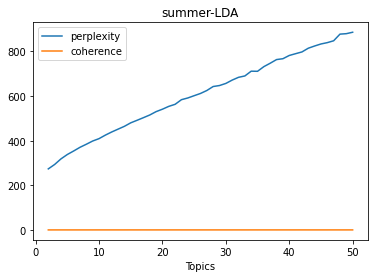

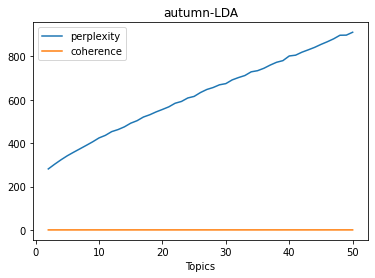

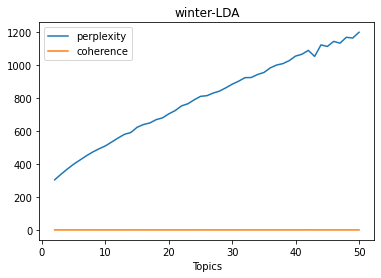

In [71]:
# Plot results
for key, _ in data_words_list.items():
    perplexity_result, coherence_result
    x = list(range(min_topic,max_topic+1))
    plt.plot(x,list(perplexity_result[key].values()), label = "perplexity")
    plt.plot(x,list(coherence_result[key].values()), label = "coherence")
    plt.xlabel("Topics")
    plt.legend()
    plt.title(f"{key}-LDA")
    plt.show()

In [72]:
# lda_result=load("season_lda")

In [73]:
topic_num = 8
max_doc = 20
# Display tweets for each topic
for key, _ in data_words_list.items():
    print(key)
    for topic_idx, values in lda_result[key][topic_num].show_topics(formatted=False,num_topics=topic_num, num_words=5):
        results = ", ".join(i[0] for i in values)
        print(f"Topic {topic_idx}: {results}")
    print()

spring
Topic 0: store, grocery, go, people, stay
Topic 1: food, people, panic, lockdown, waste
Topic 2: price, oil, low, consumer, economy
Topic 3: supermarket, store, crash, ju, teeter
Topic 4: food, consumer, demand, dog, say
Topic 5: supermarket, price, wealth, norwegian, slum
Topic 6: prior, batch, sovereign, price, today
Topic 7: price, chain, coffee, food, supply

summer
Topic 0: price, supermarket, store, due, say
Topic 1: supermarket, people, grocery, store, shopping
Topic 2: price, food, supermarket, worker, pandemic
Topic 3: food, price, grocery, store, market
Topic 4: price, essential, hand, sanitizer, people
Topic 5: food, consumer, demand, price, store
Topic 6: price, go, shopping, supermarket, online
Topic 7: grocery, store, supermarket, price, shopping

autumn
Topic 0: store, grocery, sanitizer, price, get
Topic 1: grocery, store, shopping, online, consumer
Topic 2: consumer, price, crisis, pandemic, take
Topic 3: hand, store, sanitizer, food, price
Topic 4: consumer, pa

In [74]:
# Display tweets for each topic
for key, data_words_new in data_words_list.items():
    print(f"============================{key}: Top tweets in Topics ============================")
    id2word, corpus = preprocess_LDA(data_words_new)
    topic_top_tweets = get_top_tweets(lda_result[key][topic_num], corpus, topic_num, max_doc)
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_LDA(topic_top_tweets,i))
        print()

============================spring: Top tweets in Topics ============================
Topic 0
array(['CLOSED: Summit County people, businesses preparing for UtahÂ\x92s first stay at home order. Grocery store managers telling me the stores are packed. Lunds Art Sculpture Gifts is closed. While this is tough on business, the owner says he supports this decision. #coronavirus https://t.co/J6hz8omt7R',
       'Update from when I went to the grocery store at 6am: meat is nearly gone, I was able to snag a roll of toilet paper, we took the last bread, stocked up on frozen veggies, &amp; my school STILL hasnÂ\x92t extended spring break. \r\r\n\r\r\nEveryone really is out here wildin. Stay safe #COVID2019',
       '#coronavirus just went to grocery store sad to see the lack of common courtesy people have when buying the shelves empty. Was looking at the butter and a little old lady was trying to reach a pack of butter I brought it down for her and she whispered I just want to make cookies.',
  

#### NMF

In [75]:
perplexity_list = dict()
coherence_list = dict()
topic_results_list = dict()
topic_tweets_list = dict()

# Run NMF
for key, data_words_new in data_words_list.items():
    print(key)
    topic_results, topic_tweets_results, perplexity_results, coherence_results = apply_NMF(data_words_new, min_topic,max_topic, top_words = top_word)
    perplexity_list[key] = perplexity_results
    coherence_list[key] = coherence_results
    topic_results_list[key] = topic_results
    topic_tweets_list[key] = topic_tweets_results
    

# save(topic_results_list, "season_topic_results_nmf")
# save(topic_tweets_list, "season_topic_tweets_nmf")

spring
Topic: 2      Perplexity: 1.0352649238413776      Coherence: 0.7266614083396761
Topic: 3      Perplexity: 1.0253847998347718      Coherence: 0.7414847743092922
Topic: 4      Perplexity: 1.199555576040902      Coherence: 0.7559291203163172
Topic: 5      Perplexity: 1.1119746535628108      Coherence: 0.7794144113753971
Topic: 6      Perplexity: 1.1974059064425122      Coherence: 0.7683787273471817
Topic: 7      Perplexity: 1.1214756638917986      Coherence: 0.7775141981759466
Topic: 8      Perplexity: 1.1425995629403416      Coherence: 0.7945145327793924
Topic: 9      Perplexity: 1.0784905419538793      Coherence: 0.8092041243935189
Topic: 10      Perplexity: 1.079761234088018      Coherence: 0.8160972208255215
Topic: 11      Perplexity: 1.1149938730349975      Coherence: 0.820366548393902
Topic: 12      Perplexity: 1.1179472645636102      Coherence: 0.8284554231338218
Topic: 13      Perplexity: 1.0765401336803064      Coherence: 0.8367386718403365
Topic: 14      Perplexity: 1.108

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 18      Perplexity: 1.079471742021466      Coherence: 0.8397377353255976
Topic: 19      Perplexity: 1.1059564773642712      Coherence: 0.8371814096889411
Topic: 20      Perplexity: 1.100428258147489      Coherence: 0.8463018500438906
Topic: 21      Perplexity: 1.0923899028075121      Coherence: 0.836676233214726
Topic: 22      Perplexity: 1.070685379500885      Coherence: 0.8456538453230764
Topic: 23      Perplexity: 1.0829215480346002      Coherence: 0.8458168184146485
Topic: 24      Perplexity: 1.067610982033283      Coherence: 0.8451913811861888


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 25      Perplexity: 1.071680115770136      Coherence: 0.8474863121892973
Topic: 26      Perplexity: 1.0296578353276458      Coherence: 0.8479255927631943
Topic: 27      Perplexity: 1.0503249449696077      Coherence: 0.8440218546095155
Topic: 28      Perplexity: 1.0679642346625244      Coherence: 0.8451293702051353
Topic: 29      Perplexity: 1.0682340252224258      Coherence: 0.847600921450615
Topic: 30      Perplexity: 1.0716361758581991      Coherence: 0.8503765624215494
Topic: 31      Perplexity: 1.070208903451846      Coherence: 0.8532924965128001
Topic: 32      Perplexity: 1.0564002033819553      Coherence: 0.8530669703758292
Topic: 33      Perplexity: 1.073713815544178      Coherence: 0.8570863022589628
Topic: 34      Perplexity: 1.0637779511346162      Coherence: 0.8521000476711018
Topic: 35      Perplexity: 1.0476173069635892      Coherence: 0.85537239865701
Topic: 36      Perplexity: 1.0543555081457843      Coherence: 0.8638422846619846
Topic: 37      Perplexity: 1.03542

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 26      Perplexity: 1.0896586000880977      Coherence: 0.9995788069080782
Topic: 27      Perplexity: 1.070865321006461      Coherence: 0.9996229162522409
Topic: 28      Perplexity: 1.0493998212530173      Coherence: 0.9995526609825612
Topic: 29      Perplexity: 1.0698423144037914      Coherence: 0.9993685587804917
Topic: 30      Perplexity: 1.0776552579198753      Coherence: 0.9993813943456256
Topic: 31      Perplexity: 1.0529024533774982      Coherence: 0.9993436160165843
Topic: 32      Perplexity: 1.076316198334584      Coherence: 0.9993753850743261
Topic: 33      Perplexity: 1.0701865236247128      Coherence: 0.99934761452058
Topic: 34      Perplexity: 1.0675144110609425      Coherence: 0.9993279534330227
Topic: 35      Perplexity: 1.0556741597171428      Coherence: 0.999308530693763
Topic: 36      Perplexity: 1.0498654970331176      Coherence: 0.9993358232405298
Topic: 37      Perplexity: 1.0457902366629561      Coherence: 0.9993291230681797
Topic: 38      Perplexity: 1.0680

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 46      Perplexity: 1.04774247885807      Coherence: 0.9989028896610759
Topic: 47      Perplexity: 1.0522289413187969      Coherence: 0.9987334206943205
Topic: 48      Perplexity: 1.0470430076492394      Coherence: 0.9986045973458948
Topic: 49      Perplexity: 1.0552110413633644      Coherence: 0.9979897164753558
Topic: 50      Perplexity: 1.0422041921990606      Coherence: 0.9981399617564608
autumn
Topic: 2      Perplexity: 1.0905077326652577      Coherence: 0.9998652814250244
Topic: 3      Perplexity: 1.110784505790769      Coherence: 0.9998696954626786
Topic: 4      Perplexity: 1.0944362860786794      Coherence: 0.9998453853161712
Topic: 5      Perplexity: 1.158447616990828      Coherence: 0.9998404564982966
Topic: 6      Perplexity: 1.2183361930090653      Coherence: 0.9998506492690037
Topic: 7      Perplexity: 1.0937318425363876      Coherence: 0.9998553625174932
Topic: 8      Perplexity: 1.098464274382643      Coherence: 0.9998414665852724
Topic: 9      Perplexity: 1.07982

Topic: 2      Perplexity: 1.109569472067845      Coherence: 0.9972086109613117
Topic: 3      Perplexity: 1.075989624725346      Coherence: 0.9916410693996832
Topic: 4      Perplexity: 1.0811000178342638      Coherence: 0.9921701396766462
Topic: 5      Perplexity: 1.0688774140745756      Coherence: 0.9921974136954861
Topic: 6      Perplexity: 1.1345185581279742      Coherence: 0.9929332086914465
Topic: 7      Perplexity: 1.1356258267403496      Coherence: 0.9934788139242875
Topic: 8      Perplexity: 1.1679171768412566      Coherence: 0.9934762425328556
Topic: 9      Perplexity: 1.0773986945975527      Coherence: 0.9929375403069923
Topic: 10      Perplexity: 1.133976602447893      Coherence: 0.9917183647971403
Topic: 11      Perplexity: 1.1123791223767956      Coherence: 0.9913293694353434
Topic: 12      Perplexity: 1.1257720939444822      Coherence: 0.9915831933912709
Topic: 13      Perplexity: 1.1267144686702464      Coherence: 0.9914365449629545
Topic: 14      Perplexity: 1.1054449580

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 18      Perplexity: 1.0473335455559685      Coherence: 0.9769465437399789
Topic: 19      Perplexity: 1.0965895661580294      Coherence: 0.9746624169569081
Topic: 20      Perplexity: 1.03351669592085      Coherence: 0.9721008946750942
Topic: 21      Perplexity: 1.0841019832402163      Coherence: 0.966638273093668
Topic: 22      Perplexity: 1.0341193013613512      Coherence: 0.964712434511182
Topic: 23      Perplexity: 1.0590359104121638      Coherence: 0.9621963035081321
Topic: 24      Perplexity: 1.0832498439576763      Coherence: 0.9585041226049409
Topic: 25      Perplexity: 1.0829569064705913      Coherence: 0.9600013793699921
Topic: 26      Perplexity: 1.0414013195674512      Coherence: 0.9580811056376733
Topic: 27      Perplexity: 1.0769287997307821      Coherence: 0.9543750335641817
Topic: 28      Perplexity: 1.068525674868046      Coherence: 0.9546277210375963
Topic: 29      Perplexity: 1.05003390402769      Coherence: 0.9550802294865782
Topic: 30      Perplexity: 1.063392

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 46      Perplexity: 1.050646361312978      Coherence: 0.9178052201125636
Topic: 47      Perplexity: 1.0433002475701751      Coherence: 0.9180368644477205
Topic: 48      Perplexity: 1.035462775477104      Coherence: 0.9121161426601625
Topic: 49      Perplexity: 1.0527866176449492      Coherence: 0.9183473545461677
Topic: 50      Perplexity: 1.0393693005127678      Coherence: 0.9091264146264828


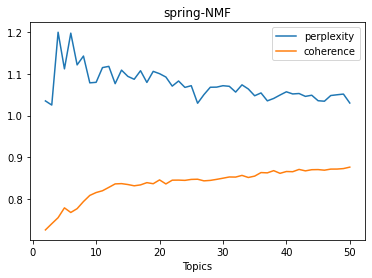

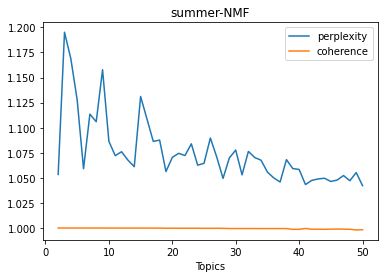

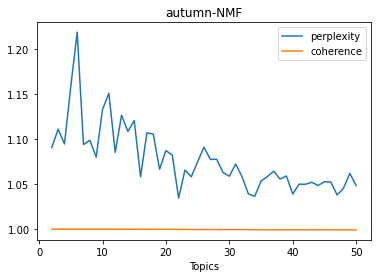

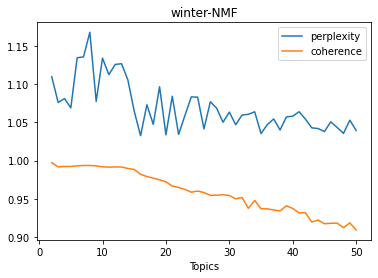

In [76]:
# Plot results
for key, data_words in data_words_list.items():
    x = list(range(min_topic, max_topic+1))
    plt.plot(x,list(perplexity_list[key].values()), label = "perplexity")
    plt.plot(x,list(coherence_list[key].values()), label = "coherence")
    plt.xlabel("Topics")
    plt.title(f"{key}-NMF")
    plt.legend()
    plt.show()

In [77]:
# topic_results_list=load("season_topic_results_nmf")
# topic_tweets_list=load("season_topic_tweets_nmf")

In [78]:
topic_num = 6
# Display topic words
for key, data_words in data_words_list.items():
    print(key)
    for key, value in topic_results_list[key][topic_num].items():
        print(f"topic {key}: ", ", ".join(value))

spring
topic 0:  store, grocery, worker, work, retail, employee, close, time, thank, get, line, hour, open, say, day, pandemic, essential, go, home, make
topic 1:  food, panic, stock, buy, supply, demand, need, buying, bank, help, get, say, due, increase, shortage, stop, chain, enough, shelf, pandemic
topic 2:  price, oil, low, market, increase, gas, demand, pandemic, fall, due, high, drop, time, hand, mask, take, sanitizer, sell, see, say
topic 3:  supermarket, worker, shelf, work, staff, get, local, empty, time, delivery, shop, day, see, thank, keep, need, hour, home, social, week
topic 4:  consumer, online, shopping, business, pandemic, help, impact, time, change, new, home, good, crisis, behavior, due, report, shop, demand, make, service
topic 5:  people, go, get, buy, need, online, hand, home, shop, shopping, sanitizer, make, stay, think, work, panic, time, stop, see, thing
summer
topic 0:  store, grocery, go, worker, mask, employee, work, wear, day, say, get, die, line, retail, e

In [79]:
# Display tweets
for key, data_words in data_words_list.items():
    print(key)
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_NMF(topic_tweets_list[key][topic_num], i, max_doc=20))
        print()

spring
Topic 0
array(['I know a lot of grocery stores are low on stock of some items. If you need something right away, try the Dollar Store, bodegas, 7-11, drug stores or ask friends/neighbors. I found some things the grocery store was sold out of at the Dollar Store yesterday. #coronavirus',
       'If you can use an app and pick-up at the grocery store that is best. If the grocery stores are not app capable they should have someone in the vestibule, possibly closing the store, to take orders for people to eliminate contact and contamination of the store. #coronavirus #Covid',
       "Sick people - Please STOP going to the grocery store! Order delivery! It's called self isolation! I'm tired of seeing people with coronavirus at the grocery store. Restaurants are more sanitary than the grocery stores! I'm ordering take-out, it's safer! #coronavirus",
       '#Ohiolockdown\r\r\n\r\r\nGrocery stores are not closing. STOP Hoarding.\r\r\nGrocery stores are not closing. STOP Hoarding.\r\r\n

#### BTM

In [80]:
perplexity_result_btm, coherence_result_btm, btm_result, phi_result = dict(),dict(),dict(), dict()
# Run BTM
for key, data_words_new in data_words_list.items():
    print(f"============================{key} Start BTM ============================")

    perplexity, coherence, model, phi= apply_BTM(data_words_new,min_topic,max_topic)
    perplexity_result_btm[key] = perplexity
    coherence_result_btm[key] = coherence
    btm_result[key] = model
    phi_result[key] = phi

# save(btm_result,"season_btm")
# save(phi_result,"season_btm_phi")

============================spring Start BTM ============================
Topic 2 Done: Perplexity: 7.031751130836987e+61  Coherence Score: -114.27183416294082


/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'


Topic 3 Done: Perplexity: 1.6520971013345857e+287  Coherence Score: -112.38596809768917
Topic 4 Done: Perplexity: 9.447213436263686e+161  Coherence Score: -113.10109216629701
Topic 5 Done: Perplexity: 6.3664377989429534e+22  Coherence Score: -111.17673683058926
Topic 6 Done: Perplexity: 1.0  Coherence Score: -115.32926344345589
Topic 7 Done: Perplexity: 1.0  Coherence Score: -110.73583017862809
Topic 8 Done: Perplexity: 3.6582016265498307e+155  Coherence Score: -108.742700969587
Topic 9 Done: Perplexity: 5.234567222096663e+109  Coherence Score: -106.69217183880788
Topic 10 Done: Perplexity: 2.9029627854420576e+292  Coherence Score: -108.6500968598586
Topic 11 Done: Perplexity: 7.122177479958616e+297  Coherence Score: -113.76544260464101
Topic 12 Done: Perplexity: inf  Coherence Score: -110.47410755698006
Topic 13 Done: Perplexity: inf  Coherence Score: -116.43696957335918
Topic 14 Done: Perplexity: inf  Coherence Score: -115.59504958889599
Topic 15 Done: Perplexity: inf  Coherence Scor

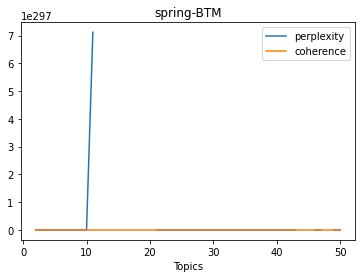

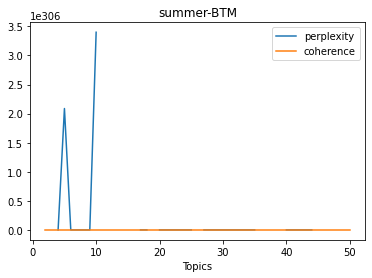

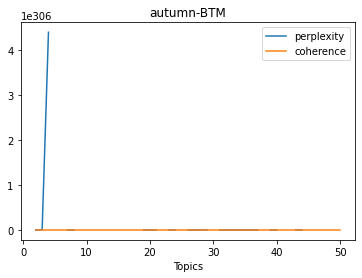

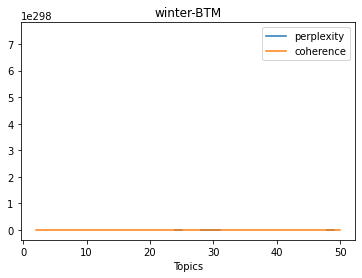

In [81]:
# Plot results
for key, _ in data_words_list.items():
    x = list(range(min_topic,max_topic+1))
    plt.plot(x,list(perplexity_result_btm[key].values()), label = "perplexity")
    plt.plot(x,list(coherence_result_btm[key].values()), label = "coherence")
    plt.xlabel("Topics")
    plt.legend()
    plt.title(f"{key}-BTM")
    plt.show()

In [82]:
# btm_result=load("season_btm")
# phi_result=load("season_btm_phi")

In [83]:
topic_num = 6
# Display topic words
for key, _ in data_words_list.items():
    print(key)
    display_BTM(phi_result[key][topic_num])

spring
Topic 0: consumer, online, price, help, business
Topic 1: store, grocery, supermarket, food, people
Topic 2: store, supermarket, grocery, people, go
Topic 3: food, store, supermarket, people, go
Topic 4: food, go, hand, supermarket, people
Topic 5: price, consumer, oil, demand, food
summer
Topic 0: price, hand, sanitizer, people, food
Topic 1: store, grocery, supermarket, go, worker
Topic 2: food, online, shopping, store, price
Topic 3: price, food, supermarket, go, store
Topic 4: price, oil, consumer, pandemic, demand
Topic 5: food, price, online, help, time
autumn
Topic 0: food, online, store, supermarket, help
Topic 1: consumer, price, business, change, help
Topic 2: price, oil, demand, market, pandemic
Topic 3: store, grocery, hand, worker, sanitizer
Topic 4: consumer, price, pandemic, new, behavior
Topic 5: store, grocery, supermarket, go, worker
winter
Topic 0: supermarket, store, people, online, get
Topic 1: hand, sanitizer, store, mask, grocery
Topic 2: consumer, price, 

In [84]:
# Display tweets
for key, data_words_new in data_words_list.items():
    print(f"============================{key} Top tweets in topic ============================")
    display(display_text_BTM(btm_result[key][topic_num], data_words_new))


============================spring Top tweets in topic ============================


topic0  \
0   appear majority british pathetic panic stricke...   
1   keep cpa view consumer good service ombud rela...   
2            shopper form long queue supermarket fear   
3   consumer protection scam alert scammer take ad...   
4   startup misfit market hire people keep food de...   
5           grocery store worker get free testing kit   
6   new time opt online shopping pandemic rwandan ...   
7   due consideration decide drop price collection...   
8   fuck overcharge rip people dirty smelly hole c...   
9             need gas price low cause deal deal deal   
10      expect gas price plummet pandemic energy news   
11  really start see impact home town empty shelf ...   
12  retailer address organisational challenge ship...   
13        dub credit agency take step protect finance   
14  government power requisition business produce ...   
15  beach close countryside share exercise common ...   
16  senschumer gopleader stimulus package pass sen...   
17  alarm empty grocery shelve food supplier retai...   
18            hoard food ashamed nurse buy food virus   
19  morrison see food box mate get parent isolatio...   

                                               topic1  \
0   worry empower panic highly concerned especiall...   
1   cole deliver box fresh veg supply nurse steven...   
2   news focus stock market corporate giant real i...   
3   always great work charity close heart call loc...   
4   drive commodity price outbreak drain acre reve...   
5   strange time take week work actually excite ba...   
6   page expose shopkeeper increase price necessit...   
7   jhanimegamer morning hope keep well stay safe ...   
8   consumer report point message video use target...   
9   ever come die hunger virus even get long food ...   
10  work right check update see page electron micr...   
11  work home use season ticket entitle refund dis...   
12  v cushy think sheet generous hoard stophoarde ...   
13  scammer attempt profit new charity report susp...   
14  wish boss scream fiiirrrrreeeddduhâ people to...   
15  interrupt pandemic bring late episodelast nigh...   
16  sad thing d whole mostly go ruin limited food ...   
17  disabled person nofood supply get ssi month fo...   
18  break nab announce give small business home ow...   
19  supermarket denmark apply pricing trick stop h...   

                                               topic2  \
0   blame retailer hike commodity price dine wine ...   
1   hero pub closed mean help peopleâhttps positi...   
2   much love spanish grocery store still toilet p...   
3     finally score toiletpaper thank realdonaldtrump   
4   beach close countryside share exercise common ...   
5   awful consequence stop live export immediately...   
6   retail lender support customer particularly vu...   
7   govt require big business supply food drug kee...   
8   recently write letter grocery store ceo respon...   
9   lockdown week spread go supermarket drugstore ...   
10  governor fault close damn beach even go grocer...   
11          buy food supermarket protection mask safe   
12  swoop special delivery rpg fortnite fun gunfig...   
13  stop panic buy itâ necessary picture old peop...   
14  add lot hygienic supermarket constantly clean ...   
15  buy people hoard sell mark price capitalism qu...   
16  support pay business also support business sta...   
17  update major grocer include asda co op lidl mo...   
18  grocery store struggle keep stock good shopper...   
19  go local supermarket morning abundance food su...   

                                               topic3  \
0   queue enter supermarket least people respect s...   
1   great home activitythe original still see worl...   
2   gifted gesture care melt heartwe discuss chaos...   
3   offer skype care package live food really hard...   
4   else paranoid fuck supermarket avoid lockdown ...   
5   great video feel kitchen clean safe family eve...   
6   find secret stash toiletpaper need quality cra... 

============================summer Top tweets in topic ============================


topic0  \
0   good part pre speech tonight acknowledge badly...   
1   oil price massive cut oil production follow me...   
2   website buy register passport drive license af...   
3   patrol park supermarket car park today include...   
4   stick home online get free donation shopsign g...   
5   term socialdistancing first enter lexicon week...   
6   totally understand severe physical health prob...   
7                  probably chill average familyhttps   
8   shopper warn wear glove supermarket coronaviru...   
9   order premium return consumer business affect ...   
10  food rescue group busy keep high demand outbre...   
11  meet ceo major energy company discuss fall pri...   
12  buy frozen veggie limit trip grocery storenow ...   
13  founder say base business never see demand onl...   
14  implement negotiate reduce internet price pand...   
15  scammer take advantage fear anxiety surround q...   
16  safety practice supermarket provide safe place...   
17  synthesis income relate finding recommendation...   
18  walk supermarket today many ppl various type m...   
19             favorite emergency food gain new fan u   

                                               topic1  \
0   take kid grocery store today absolute necessit...   
1   trump recommend people take drug prophylactic ...   
2   test complete confirm case death key concern t...   
3   picture trip local grocery store dead land des...   
4   thing â know single parent â check perhaps g...   
5   cut benchmark interest rate extend consumer lo...   
6                      tell people use hand sanitizer   
7   order premium return consumer business affect ...   
8   stuck home smell hand sanitizer create toomuch...   
9   supermarket staff member test positive shopper...   
10  see much percent percent increase demand indiv...   
11  dairy farmer affect milk price cut supermarket...   
12  empty shelf supermarket conclude isolation peo...   
13  atomic robot comic_strip toy reduce price noti...   
14  realise vulnerable people online shopping acco...   
15  think easy option walking dog perhaps alone dr...   
16  man accuse sneeze cough people christchurch su...   
17  people keep say show important people society ...   
18  normal problem worker deserve decent secure we...   
19  share profit low crude oil price people pandem...   

                                               topic2  \
0   petrol diesel rate stagnant lockdown oil price...   
1   cannalogue introduce inclusive compassionate c...   
2   faith butcher member marketing team explore im...   
3   demand food service worker receive full pay he...   
4   matter live good chance community hungry many ...   
5               deal close oil price likely stabilize   
6   naivas supermarket award kind hearted police o...   
7   guy itâ clear stay home afraid get fresh air ...   
8   order premium return consumer business affect ...   
9   try try keep sell crisis learn convince custom...   
10  think easy option walking dog perhaps alone dr...   
11  speculation uncertainty total australian red m...   
12         add retail signage help store deal concern   
13             favorite emergency food gain new fan u   
14  mission time store close pandemic help safely ...   
15  part jimmy quiroga r design virtual motherâ d...   
16  wh say limit trip grocery store pharmacy week ...   
17  launch essential service let customer order vi...   
18  realdonaldtrump get big deal test impressive c...   
19  day trump refuse use full power defense produc...   

                                               topic3  \
0   look people shop empty food shelf supermarket ...   
1   last month governor step protect state lot fed...   
2             easyjet dream go supermarket find pasta   
3   nobodyâ case crude oil regain enormous loss i...   
4               crude oil soar producer agree indilen   
5   make senior especially vulnerable serious infe...   
6   odd go supermarket buy usual food supply satur... 

============================autumn Top tweets in topic ============================


topic0  \
0   lick hand spread disease deliberately touch su...   
1   enterprise reporter embe place see store manag...   
2   bbcnews mask argument mask stand outside conta...   
3   online shopping way restriction metropolix online   
4   stay date center food weekly webinar regard co...   
5   lockdown fear contraceptive stock out supplier...   
6   apparently plenty toilet paper kind people buy...   
7   captainâ log socialdistance day point desire ...   
8   rebecca go grocery shopping wear mask make yel...   
9   rabbit full sht people use wayspeoplearethewor...   
10  update essential page new late ndis update cha...   
11  distillery produce handsanitizer crisis smallb...   
12  lot people shop grocery online try avoid somet...   
13  thread time crisis essential service job take ...   
14  demand job many sector urgent need worker indu...   
15  paycheck falter bank agree consumer relief pac...   
16  pandemic specifically friend service help food...   
17  oil price rise market await decision oilprice ...   
18  hand sanitizer hard find long long time enough...   
19  global pandemic dramatic impact economy partic...   

                                               topic1  \
0   big fine ticket give shopper supermarket queue...   
1   consumer company want mine database million cu...   
2   prepper retail store owner accuse deceive publ...   
3   late report show change new case drop daily po...   
4   food civil supply consumer affair fix price ve...   
5   milk price drop low see year dairy farmer dump...   
6   update section website update information cons...   
7   outbreak shut hundred thousand store country r...   
8   short term business respond immediate challeng...   
9   hope teach stop judge people base job title ea...   
10  poor face problem due spiral price essential g...   
11  start ban customer custexp thread customer alw...   
12  stay home stay safe stayhomestaysafe socialdis...   
13  hulu friend business go good day maybe think s...   
14  rather stay unemployed risk life grocery store...   
15  opine fmcg sector get back decent growth month...   
16  world make sense print dollar partially mitiga...   
17  lately get cute go grocery store brooklynmadis...   
18  consumer datum rescue tech researcher illumina...   
19  today salute hero front line put word supermar...   

                                               topic2  \
0         see good time avoid queue local supermarket   
1   concern shopping online pandemic leave box pos...   
2   innovative sanitizer spray coronaalert coronao...   
3                       drop sanitizer kill germ germ   
4   leverage innovative methodology new technology...   
5   increase grocery volume consequence measure cu...   
6   make home shine cleaner diycleane springcleane...   
7   grocery store rant store rightfully limit numb...   
8   lago market record drop price perishable food ...   
9   complaint call relate scam consumer affair age...   
10  get range measure support customer tough time ...   
11   woman arrest lick worth grocery item supermarket   
12  new tonight news assault charge lay grocery st...   
13  onshore domestic export price natural gas cont...   
14  terrifying video show cough spread cloud super...   
15  skill acquire many year ago prove useful avoid...   
16  environmental sustainability oil company cut s...   
17  top health official warn go grocery store day ...   
18  word man always staysafe sanitizer washyourhan...   
19  new consumer behaviour outlast pandemichttps m...   

                                               topic3  \
0   house price read get question post house price...   
1   build business online store day day code run r...   
2   stay foot apart grocery store essential newyor...   
3   start consumer demand digital banking never gr...   
4   scary video show single cough spread supermark...   
5      hand sanitizerliterally toilet essentialworker   
6   current topic event tiger essentiale learnings... 

============================winter Top tweets in topic ============================


topic0  \
0   photo show single cough travel supermarket ais...   
1              spur falloff consumer expectation past   
2         run money demand continue grow due pandemic   
3   flipkart tataconsumer announce partnership ena...   
4   global concern household finance change week g...   
5   special data bundle give horrible service high...   
6   look family activity home easter devise game q...   
7   shop online easter weekend make sure stay vigi...   
8   grocery contest alert giveawayalert competitio...   
9   confront animation show far infect person coug...   
10                     small joy life age toiletpaper   
11  pocketdump get weird damn carry hand sanitizer...   
12  online shopping stuff yet use available sale a...   
13  pandemic create increase demand industrial col...   
14  milk opportunity buy company hit nation low pr...   
15          get hand sanitizer face masksfeel lottery   
16                         key food price surge upend   
17                           warn hidden medical cost   
18                        join amazing contest vishal   
19  quarantine shopping bread make machine second ...   

                                               topic1  \
0   wait people actually think cellular network ca...   
1   recent enter serious phase fight tackle tradit...   
2   already recession dozen economist say job loss...   
3   kid neighbourhood draw local grocery store pro...   
4   plough last crop double effect drought mean qu...   
5   scared play catch epidemic quarantine comedy s...   
6         run money demand continue grow due pandemic   
7   take look key emerge consumer trend associate ...   
8   news prison guard receive hand sanitizer incar...   
9   nascent drone delivery service boominghttps ra...   
10  spring housing market much slow normal home pr...   
11  consumer c retaildive retailnew consumer retai...   
12  crosse world day day live change dramatically ...   
13  stay safe stay home use mask sanitizer b hand ...   
14                        foot distancing shop enough   
15  consumer report indispensable ever pandemic ml...   
16  get washing grocery really scary fuckbut real ...   
17      wire algorithm retail store future anticipate   
18  insight consumer researchhttps wreak havoc bus...   
19                             people online shopping   

                                               topic2  \
0   recognize force many cook mccormick set intera...   
1   oil decline initial jump historic deal top pro...   
2   stayhomesavelive supermarket tourism drive tow...   
3   consumer report test facebook ad claim reject ...   
4   bad find great account follow start spew polit...   
5        start kill make good bad coronavirusoutbreak   
6   business use condition unfairly hike price put...   
7   also say smart genius even say stable genius r...   
8   nail polish manufacturer produce alcohol base ...   
9   commerce sale classic shift temporarily consum...   
10  stop wear contact lense help guard infection s...   
11  touch face mouth preferably cover nose mouth m...   
12  seem year live cocoon liberal propaganda purve...   
13  telemedicine telepathy combine beautiful thing...   
14  grocery contest alert giveawayalert competitio...   
15  let honest socialdistancing suck make suck lit...   
16  expert warn face economic social collapse resu...   
17  home improvement hardware store keep steady pa...   
18  extremely engaging session key trend consumer ...   
19  kwawesome see hand sanitizer disinfectant wipe...   

                                               topic3  \
0   imagine make artist natural understand marketi...   
1   open living room curtain guy girlfriend grocer...   
2   forget sunbathe people treat weekly shop super...   
3   walk grocery store keep distance time challeng...   
4   track trajectory consumer behavior thick check...   
5   new infographic consumer behavior constantly e...   
6   read latest help tsla use interesting turn phr... 

#### CorEx

In [85]:
corex_result = dict()
tc_result = dict()
# Run corex with anchor words "oil"
for key, data_words_origin in data_words_list.items():
    print(f"============================{key} Start CorEx ============================")

    tc, corex_models = apply_Corex(data_words_origin, min_topic, max_topic,anchor_words=["oil"])
    corex_result[key] = corex_models
    tc_result[key] = tc

# save(corex_result, "season_corex")

============================spring Start CorEx ============================
Topic 2 Total Covraiance: 0.6869106103258884
Topic 3 Total Covraiance: 0.653612662541263
Topic 4 Total Covraiance: 0.7529938917603443
Topic 5 Total Covraiance: 0.9175323980164527
Topic 6 Total Covraiance: 0.8113782688839473
Topic 7 Total Covraiance: 0.9215268061795141
Topic 8 Total Covraiance: 0.9202414773691139
Topic 9 Total Covraiance: 0.7993924457460703
Topic 10 Total Covraiance: 0.9485285530770848
Topic 11 Total Covraiance: 1.121501149985972
Topic 12 Total Covraiance: 1.1384074180090449
Topic 13 Total Covraiance: 0.9236049553483748
Topic 14 Total Covraiance: 1.0341352443780223
Topic 15 Total Covraiance: 1.0771952533157678
Topic 16 Total Covraiance: 0.8760249872633712
Topic 17 Total Covraiance: 1.018326422196439
Topic 18 Total Covraiance: 1.1881566206691108
Topic 19 Total Covraiance: 0.9714646181253823
Topic 20 Total Covraiance: 1.2187953822591957
Topic 21 Total Covraiance: 1.1825107851073415
Topic 22 Total 

In [86]:
# save(tc_result, "season_tc")

In [87]:
# tc_result= load("season_tc")
# corex_result= load("season_corex")

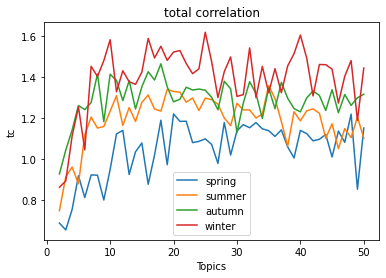

In [88]:
# Plot results
x = list(range(min_topic,max_topic+1))
for key, _ in data_words_list.items():
    plt.plot(x,list(tc_result[key].values()), label = key)
    # print(key)
plt.legend()
plt.title("total correlation")
plt.xlabel("Topics")
plt.ylabel("tc")
plt.show()

In [89]:
topic_num = 12
# Display topic words
for key, _ in data_words_list.items():
    print(key)
    topics = corex_result[key][topic_num].get_topics()
    display_corex(topics)


spring
Topic 0: store, grocery, ~price, retail, ~consumer
Topic 1: health, public, emergency, state, government
Topic 2: help, support, small, vulnerable, business
Topic 3: people, think, bad, know, need
Topic 4: social, distancing, follow, post, measure
Topic 5: online, shopping, shop, order, deliver
Topic 6: demand, ~supermarket, increase, impact, pandemic
Topic 7: sanitizer, hand, mask, glove, use
Topic 8: panic, food, buy, buying, stock
Topic 9: toilet, paper, roll, toiletpaper, find
Topic 10: worker, home, work, stay, driver
Topic 11: go, get, week, last, day
summer
Topic 0: price, oil, ~supermarket, low, ~consumer
Topic 1: mask, wear, glove, face, stop
Topic 2: go, week, last, back, thing
Topic 3: stay, home, safe, delivery, keep
Topic 4: hand, sanitizer, use, clean, fight
Topic 5: test, happen, positive, itâ, shelf
Topic 6: toiletpaper, paper, ~company, ~many, toilet
Topic 7: store, grocery, worker, retail, employee
Topic 8: socialdistancing, line, try, ~state, ~economy
Topic 9:

In [90]:
# Display tweets
for key, _ in data_words_list.items():
    print(f"============================{key} Top tweets in topics ============================")
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_corex(corex_result[key][topic_num], i, max_doc=10))
        print()

============================spring Top tweets in topics ============================
Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(['While I fully support healthcare professionals on the front lines of the #covid19 #Coronavirus #pandemic Can we shout out to everyone who still has to work! Retail/grocery store employees, utility technicians, truck drivers, government, military, police and so on. Thank them all!',
       'We wanted to take a moment to thank all of those working on the front lines to combat COVID-19. Healthcare workers, those in manufacturing and transportation, retail and grocery store employees, scientists, and everyone working from home to flatten the curve: THANK YOU. https://t.co/crCVrL9CQI',
       'Thank you, to all the officials, who are acting like adults, and working on the Wuhan Flu. Thank you Medical Personal, standing by and ready. But a huge thank you, to retail grocery store employees. They are the heros of the